In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn import metrics

from IPython.display import display, Markdown
def short_print(text):
    display(Markdown(text+'\n'))

In [2]:
from reddit_thread_scraper import fetch_all_posts, build_dataframe_from_posts

# import dataset
thread_name = 'AmItheAsshole'
posts_num = 25000

posts = fetch_all_posts(thread_name, posts_num)

df = build_dataframe_from_posts(posts)

df['NTA'] = np.where(df['first_comment'].str.contains('NTA'), 1, 0)

df['text'] = df[ 'text' ].apply( str )
df['text_len'] = df[ 'text' ].apply( len )

# Consider only texts shorter than appr. 512 tokens. 
df = df[ (df['text_len'] < 500*4) & (df['num_upvotes'] > 1) ].copy()

df['first_comment'] = df[ 'first_comment' ].apply( str )
df['first_comment_len'] = df[ 'first_comment' ].apply( len )

df_short = df[ (df['first_comment_len'] > 5*4)  ]

### Let's look into the Main Sentiment. Again

In [4]:
from transformers import pipeline

# Initialize sentiment analysis pipeline using PyTorch
sentiment_pipeline = pipeline('sentiment-analysis', truncation=True)

def get_sentiment(text):
    result = sentiment_pipeline(text)
    return result[0]['label']

df_short['sentiment'] = df_short['text'].apply( get_sentiment )

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [5]:
df_short['sentiment'].value_counts()

sentiment
NEGATIVE    12097
POSITIVE      648
Name: count, dtype: int64

In [6]:
print('Average number of upvotes by sentiments: ')
df_short.groupby(['sentiment'])['num_upvotes'].agg('mean')

Average number of upvotes by sentiments: 


sentiment
NEGATIVE    346.620898
POSITIVE    203.493827
Name: num_upvotes, dtype: float64

## Existing models

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load GoEmotions model and tokenizer
model_name = "bhadresh-savani/bert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Initialize the pipeline
emotion_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Create a function to classify emotions for each text
def classify_emotions(text):
    # Get the top emotion(s) predicted by the model
    results = emotion_classifier(text, top_k=10)  
    
    return results  

print("An example of emotion classes: \n")
for text in df_short['text'][0:2]:
    emo_list = classify_emotions( text )
    for item in emo_list:
        print( item )
    print('-'*40)


An example of emotion classes: 

{'label': 'anger', 'score': 0.9841641783714294}
{'label': 'sadness', 'score': 0.013315281830728054}
{'label': 'joy', 'score': 0.0009154121507890522}
{'label': 'love', 'score': 0.0007258521509356797}
{'label': 'fear', 'score': 0.0006314266356639564}
{'label': 'surprise', 'score': 0.00024790820316411555}
----------------------------------------
{'label': 'anger', 'score': 0.9558292627334595}
{'label': 'sadness', 'score': 0.03241502121090889}
{'label': 'fear', 'score': 0.007420215290039778}
{'label': 'joy', 'score': 0.0034718643873929977}
{'label': 'surprise', 'score': 0.00044146287837065756}
{'label': 'love', 'score': 0.0004222277784720063}
----------------------------------------


## What if we need more emotions?

In [8]:
from sentence_transformers import SentenceTransformer

embedding_model_name = 'mixedbread-ai/mxbai-embed-large-v1'

embedding_model = SentenceTransformer(embedding_model_name)

In [9]:
# Set a list of mood
moods_dict = {
    "Angry": "Feeling outraged, infuriated, resentful, irate, offended, caught up in conflicts or injustice.",
    "Joyful": "Feeling elated, delighted, content, blissful, satisfied, with a sense of positive achievement.",
    "Confused": "Feeling perplexed, baffled, disoriented, uncertain, struggling to grasp the meaning of a situation.",
    "Sad": "Feeling heartbroken, sorrowful, despondent, downcast, deeply touched by loss or disappointment.",
    "Anxious": "Feeling uneasy, apprehensive, nervous, tense, worried about future events or personal relationships.",
    "Vindicated": "Feeling validated, justified, triumphant, proven right after a dispute or long-standing disagreement.",
    "Betrayed": "Feeling deceived, let down, disillusioned, hurt by a breach of trust in a close relationship.",
    "Hopeful": "Feeling optimistic, confident, expectant, positive, believing that better things were on the horizon.",
    "Regretful": "Feeling remorseful, apologetic, rueful, wishing could undo past choices or mistakes.",
    "Resigned": "Feeling resigned, accepting, subdued, defeated, realizing there was no way to change the situation.",
    "Indignant": "Feeling outraged, morally offended, righteous, deeply angered by perceived unfairness or wrongdoings.",
    "Relieved": "Feeling reassured, at ease, comforted, finally free from worry after resolving a troubling issue.",
    "Sentimental": "Feeling wistful, reflective, sentimental, longing for the past with warm and fond memories.",
    "Fearful": "Feeling frightened, alarmed, uneasy, haunted by dread and concerns about negative outcomes.",
    "Grateful": "Feeling thankful, appreciative, humbled, full of gratitude for the support or kindness received from others.",
    "Embarrassed": "Feeling self-conscious, awkward, mortified, ashamed of a social misstep or personal blunder.",
    "Guilty": "Feeling remorseful, burdened, regretful, weighed down by a sense of responsibility for my wrong actions.",
    "Lonely": "Feeling isolated, abandoned, disconnected, yearning for companionship or emotional closeness.",
    "Surprised": "Feeling astonished, taken aback, startled, caught off guard by something unexpected or surprising.",
    "Used": "Feeling exploited, taken for granted, manipulated, as if someone's worth had been diminished by others' selfishness.",
    "Wronged": "Feeling mistreated, unjustly dealt with, victimized, hurt by the unfair actions or decisions of others."
}

# Get mood embeddings
mood_embeddings = {mood: embedding_model.encode([description]) for mood, description in moods_dict.items()}

# Compare each post's embedding to each mood
def assign_mood_to_post(post_embedding, mood_embeddings):
    post_embedding = np.array(post_embedding).reshape(1, -1)
    # Calculate cosine similarity between the post embedding and each mood embedding
    similarities = {mood: metrics.pairwise.cosine_similarity(post_embedding, mood_embedding)[0][0] for mood, mood_embedding in mood_embeddings.items()}
    # Find the mood with the highest similarity score
    dominant_mood = max(similarities, key=similarities.get)
    
    return dominant_mood, similarities

# Example of applying this to your data
df_short['dominant_mood'] = df_short['text_embeddings'].apply(lambda embedding: assign_mood_to_post(embedding, mood_embeddings)[0])
df_short['mood'] = df_short['text_embeddings'].apply(lambda embedding: assign_mood_to_post(embedding, mood_embeddings)[1])

# Make a copy of dataset if it takes long to calculate
#df_short.to_csv('text_vectors_mood.csv', index=None)


In [10]:
print('Average number of upvotes grouped by dominant_mood: ')
df_short.groupby(['dominant_mood'])['num_upvotes'].agg('mean').sort_values(ascending=False)

Average number of upvotes grouped by dominant_mood: 


dominant_mood
Angry          606.404255
Regretful      506.885572
Sad            466.170000
Indignant      465.592920
Embarrassed    437.767081
Vindicated     404.347305
Betrayed       344.655559
Guilty         303.317896
Grateful       277.313131
Confused       236.166667
Resigned       182.094340
Relieved       176.000000
Anxious        175.856631
Lonely         163.659193
Fearful         74.181818
Joyful          49.000000
Nostalgic       25.771930
Surprised        7.000000
Hopeful          5.000000
Name: num_upvotes, dtype: float64

## Complex feelings

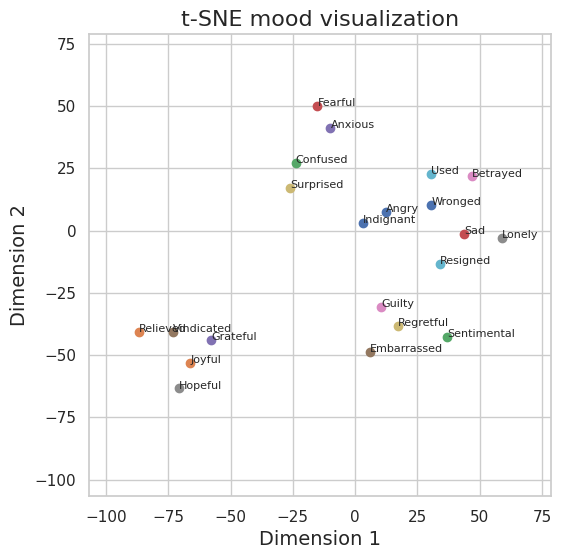

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

# Extract moods
moods = list(mood_embeddings.keys())
# Extract embeddings from mood_embeddings
embeddings = np.array([mood_embeddings[mood][0] for mood in moods])  

# Reduce dimensionality using t-SNE with adjusted perplexity
# Set perplexity lower than the number of samples (moods)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)  
reduced_embeddings = tsne.fit_transform(embeddings)

# Create a scatter plot
plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")

# Plot each mood as a point
for i, mood in enumerate(moods):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.text(reduced_embeddings[i, 0] + 0.01, reduced_embeddings[i, 1], mood, fontsize=8)

# Ensure both axes have the same limits
plt.xlim(min(reduced_embeddings[:, 0:1]) - 20, max(reduced_embeddings[:, 0:1]) + 20)
plt.ylim(min(reduced_embeddings[:, 0:1]) - 20, max(reduced_embeddings[:, 0:1]) + 20)

# Set equal scaling for x and y axes
plt.gca().set_aspect('equal', adjustable='box')

plt.title("t-SNE mood visualization", fontsize=16)
plt.xlabel("Dimension 1", fontsize=14)
plt.ylabel("Dimension 2", fontsize=14)
plt.show()

## Let's group by mood. Why Affinity Propagation?

As it's obvious from the plot above the comples emotions tends to form their own clusters, which are hard to separate for nuance analysis. 

Affinity Propagation is particularly well-suited for complex clustering. It automatically discovers the optimal number of clusters without requiring a predefined value, which is crucial when clusters are intricate and multifaceted. Instead of relying on synthetic centroids, Affinity Propagation identifies exemplars (actial data points). The algorithm effectively groups poins that share subtle similarities, even when of classes are not clearly defined, making it a great fit for complex emotional content.

In [12]:
data = pd.DataFrame( df_short['mood'].tolist()) 

data.head()

,Angry,Joyful,Confused,Sad,Anxious,Vindicated,Betrayed,Hopeful,Regretful,Resigned,Indignant,Relieved,Nostalgic,Fearful,Grateful,Embarrassed,Guilty,Lonely,Surprised
0,0.463483,0.389687,0.462795,0.488182,0.480671,0.504344,0.583913,0.374581,0.538539,0.459305,0.465943,0.437985,0.501560,0.439938,0.466672,0.491009,0.555854,0.483058,0.389660
1,0.469788,0.401722,0.453339,0.469447,0.494828,0.441002,0.519423,0.401341,0.488413,0.489325,0.420694,0.450727,0.435043,0.468733,0.481112,0.476080,0.504042,0.498512,0.408830
2,0.410632,0.450679,0.419070,0.463338,0.473811,0.486714,0.507374,0.403064,0.494174,0.417763,0.416433,0.442916,0.493489,0.426295,0.494778,0.470016,0.489829,0.468652,0.381527
3,0.457888,0.454548,0.459030,0.450468,0.481365,0.489132,0.514514,0.429001,0.490758,0.479252,0.462527,0.468236,0.434494,0.470751,0.481872,0.506983,0.491925,0.516393,0.447610
4,0.491471,0.460231,0.461006,0.523039,0.512098,0.471447,0.542902,0.428985,0.528173,0.564420,0.487000,0.494120,0.495475,0.499522,0.502905,0.524646,0.549600,0.503759,0.437834


In [13]:
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler

# Optionally scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

af = AffinityPropagation(random_state=0)
af.fit(scaled_data)

# Cluster labels and exemplars
labels = af.labels_
exemplars = af.cluster_centers_indices_

# Get the clusters associated with each exemplar
clusters = [np.where(af.labels_ == i)[0] for i in range(len(exemplars))]

# View exemplars and their associated posts
print('Number of exemplars: ', len(exemplars))


Number of exemplars:  349


## A recipe for the drama. 
### The right proportions

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

exemplars_texts =  df_short['text'][exemplars]

mood_descriptions = [moods_dict[mood] for mood in moods]

# Step 1: Vectorize exemplars and mood descriptions using TF-IDF
vectorizer = TfidfVectorizer()
exemplar_vectors = vectorizer.fit_transform(exemplars_texts)
mood_vectors = vectorizer.transform(mood_descriptions) 

# Step 2: Calculate similarity between each exemplar and all moods
top_n = 5 
exemplar_moods = []

for i, exemplar_vector in enumerate(exemplar_vectors):
    similarities = cosine_similarity(exemplar_vector, mood_vectors).flatten()
    top_mood_indices = similarities.argsort()[-top_n:][::-1] 
    assigned_moods = [moods[index] for index in top_mood_indices]
    exemplar_moods.append(assigned_moods)

# Step 3: Print the assigned moods for each exemplar
exemplar_moods_text = [ ', '.join(assigned_mood_list) for assigned_mood_list in exemplar_moods ]

#Create a new column 'mood_label' in df_short to store the cluster mood
df_short['mood_label'] = ""

#Iterate over the clusters and assign mood labels
for cluster_index, cluster in enumerate(clusters):
    # Get the mood assigned to this cluster's exemplar
    cluster_moods = exemplar_moods[cluster_index]
    
    # Combine the moods into a string, e.g., "Sad, Anxious"
    mood_label = ", ".join(cluster_moods)
    
    #Assign the mood label to each post in the cluster
    for post_index in cluster:
        df_short.at[post_index, 'mood_label'] = mood_label
        df_short.at[post_index, 'mood_cluster'] = cluster_index
        
for i, assigned_mood_list in enumerate(exemplar_moods[0:10]):
    print(f"Exemplar {i}: Top {top_n} Moods - {', '.join(assigned_mood_list)}")

Exemplar 0: Top 5 Moods - Surprised, Confused, Resigned, Guilty, Fearful
Exemplar 1: Top 5 Moods - Resigned, Relieved, Sentimental, Grateful, Guilty
Exemplar 2: Top 5 Moods - Betrayed, Confused, Guilty, Resigned, Hopeful
Exemplar 3: Top 5 Moods - Grateful, Resigned, Used, Confused, Guilty
Exemplar 4: Top 5 Moods - Sentimental, Resigned, Guilty, Confused, Betrayed
Exemplar 5: Top 5 Moods - Hopeful, Grateful, Sentimental, Lonely, Guilty
Exemplar 6: Top 5 Moods - Resigned, Relieved, Confused, Embarrassed, Hopeful
Exemplar 7: Top 5 Moods - Resigned, Confused, Hopeful, Sentimental, Grateful
Exemplar 8: Top 5 Moods - Confused, Wronged, Grateful, Resigned, Sad
Exemplar 9: Top 5 Moods - Wronged, Sentimental, Relieved, Indignant, Fearful


## Inspect the combinations

In [15]:
for text in df_short['text'][clusters[3]]:
    print('-------------------')
    short_print(text.replace('\n', ' '))


-------------------


I recently bought a certified pre-owned car with an extended warranty. Then I saw the error in my ways buying an extended warranty. I ended up refinancing my loan to reduce my APR by 3% since financing through the dealership was higher. I was told by Toyota that in order to cancel my gap insurance and extended warranty I needed to fax in a letter with certain info stating that I wanted to cancel both. I faxed it over about 3 weeks ago and never received any refund.   I called customer service back and the guy told me that my gap was automatically canceled when I refinanced but they never canceled my extended warranty then said he did not receive the fax stating I wanted to cancel. I have 30 days after purchase to get a 100% refund and they tried to make me jump through hoops to prolong that timeframe. I called customer back telling them I did submit the fax and told them the date and time as well as receiving a notification that it was successfully sent. Once he located it in their system he told me it was never canceled because it was never opened by them so it was still active. I told  them I sent it weeks ago and they had ample time to do so. He said all he can do now is cancel it and I'd get a refund check in the mail in 30 days for both.   I told him how shady they are because they seem to not want to refund me my money and I should be receiving a refund of around 4k which can be used to pay off my loan with my refinancer. I accused him of hoarding my money and stated that someone is clearly not doing their job if the fax was unviewed for 3 weeks. He said he does not know why the fax was not viewed yet but said he can process the refund now but that I would not get 100% refund anymore since it was after 30 days. I told him I faxed in the letter before the 30 days they just never processed it so it was their fault.


-------------------


I have worked for the same person for about 18 years, it’s a small blue collar company with 16-18 employees at our largest and just him and I for several years. A few years ago he bought out another company, he screwed around and ran the business into the ground and the company is broke. I have known it was time to leave since last September but have been waiting till spring to make my move. Since November 8 employees have quit, the last 3 were a month ago, leaving just me again.   Friday I got a letter from the insurance company stating that my policy “is about to be or already has been terminated “ I had a prescription refill coming due in a week so I go to pick it up Saturday and the pharmacist informs me that my insurance policy is not good anymore. After some further investigation on the insurance app, I see where the policy is inactive since Jan 1.    I had a medical procedure done the first of the year and a follow up appointment. In the app under those claims it says that I’m responsible for the entire bill totaling about $10k.   My boss nor the last remaining office employee which is probably who handled the paperwork to cancel the insurance policy has mentioned anything about having to cancel it. In the morning I plan on confronting him about it and then plan on walking out, WIBTA if I don’t work out a notice?


-------------------


I'm a 19 year old male and my Father 58.   Context, when I was 9 years old I got into an ATV accident at my mom's boyfriend (at the time) property. I ended up having 2 surgeries because of this and left with a narly scare on the top of. I stupidly wasn't wearing a helmet.  My dad sued the homeowners insurance company on my behalf and won a good bit of money for me that I was supposed to have access to when I turned 18 (around $110k). The original ruling was that the money was to be in a secure account and given to me in increments at the ages of 18, 21 and 25. However, my dad fought this and was given sole conservatorship over the money. He was not to spend it for himself or permission from the court.  Fast forward to when I turned 18 and my dad and I signed papers from the court terminating his conservatorship and was ordered that he transfer the money into my account. This is where the problems truly began. For the past year he's been being dodgy about the money every time I brought it up. Eventually I had enough and started demanding the money and proof that he still had it. Just last month he admitted that it was ALL GONE. I'm absolutely livid.  I contacted a lawyer for advice and how to proceed moving forward. I was told that I can sue him for "Treble damages" meaning that he would owe me triple of the original amount. Now to be honest my father and I have had other fall outs over the years other than the money and our relationship was already falling apart, so I really don't care what type of repercussions he would face if I move forward and sue him.   If I win the treble damage lawsuit I know he can't afford to pay me and would be forced to sell his property to pay me. This would leave him homeless. WIBTA?


-------------------


WIBTA for calling a tow truck to collect my neighbor’s boyfriend’s car? We live in an apartment complex with assigned parking spots in a small lot, and the dude does not live here but is here daily. There are signs stating “Tenant parking only; all others will be towed”. Guests are meant to park on the street.  A few months ago, he started making his own parking spot, completely outside the painted lines, which blocks two cars from being able to maneuver through our parking lot, blocks visibility, and creates an absolute nightmare for people who actually pay rent to live here. I even tried to do him a solid by telling him about my former roommate’s parking spot that was still unassigned; the dude completely ignored me and then rather than parking his car in the unassigned spot, his girlfriend (the tenant) has parked a disabled vehicle in the spot for months. So he continues to park in his imaginary spot and block the parking lot. WIBTA for just calling a tow truck to take care of the problem?


What do the post's have in common? 

Betrayal of Trust? Looks like this. Financial repercussions as a result of the betrayal.

The OPs also express strong indignation, and moral outrage at the unfairness of their situations.

## The best cluster representative... emotional blueprint

Same is in the Part 1. Lets **identify the most representative text within a group of clustered data**. A function calculats the of all the text embeddings in a cluster and then finding the text that is closest to that centroid. Is it the same as exampler?

Then, we **write a summery**. Once the most representative text is identified, LLM takes over. A function interacts Groq's API, and requests to generate a concise summary of the selected text. 

The two step approach help to distill complex content into clear representative.

In [16]:
from groq import Groq
from sklearn.metrics import pairwise_distances_argmin_min

# Groq API key
client_grq = Groq(api_key="YOUR_KEY")

def get_text_for_class(df, class_name, cluster_column, text_column, vector_column):

    try:
        # Convert the vector column to a NumPy array of embeddings
        embeddings = np.array(df[vector_column].tolist())

        # Extract the embeddings for the specified class
        class_embeddings = embeddings[df[cluster_column] == class_name]

        # Check if there are any embeddings to process
        if len(class_embeddings) == 0:
            return None  # No data available for this class

        # Calculate the centroid of the class
        class_centroid = class_embeddings.mean(axis=0)

        # Find the index of the closest text to the centroid
        closest, _ = pairwise_distances_argmin_min([class_centroid], class_embeddings)

        # Get the original index of the closest text in the DataFrame
        original_index = df[df['mood_cluster'] == class_name].index[closest[0]]

        # Return the text closest to the centroid
        return df.loc[original_index, text_column]

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def get_groq_response(prompt, instruction, model="gemma-7b-it"):
    
    try:

        completion = client_grq.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "system","content": instruction
                },
                {
                    "role": "user", "content": prompt
                }
            ],
            temperature=0.2,
            max_tokens=500,
            top_p=1,
            stream=True,
            stop=None,
        )

        string = ''
        for chunk in completion:
            string += chunk.choices[0].delta.content or ""
        string = string.replace('\n', ' ')
        #print(string)
        return string 

    except Exception as e:
        print(f"An error occurred: {e}")
        return "No information" 


In [17]:
popularity_table = df_short.groupby(['mood_cluster'])['num_upvotes'].agg('mean').sort_values(ascending=False)
popularity_table.head(10)

instr = 'Summarize the story in one sentence. Define emotions of the narrator.'

for idx in popularity_table.index[0:10]:
    text = get_text_for_class(df_short, idx, 'mood_cluster','text', 'text_embeddings')
    
    if text:  # Ensure that text is not None before proceeding
        summary = get_groq_response(text, instr, model="gemma-7b-it")
        print(f"Cluster { df_short[df_short['mood_cluster'] == idx]['mood_label'].values[0] }:")
        short_print(summary+ '\n')
        print("---------------------------------------------------------")
        
    else:
        print(f"No representative text found.")

    

Cluster Sentimental, Resigned, Sad, Relieved, Used:


**Summary:** A family with a son who has Cerebral palsy grapple with tensions and emotional conflict when their brother and sister-in-law visit, demanding to swap bedrooms due to SIL's pregnancy, despite previous arrangements and safety concerns.  **Narrator's Emotions:** Frustration, concern, protectiveness, and a sense of being misunderstood and inconsiderate.



---------------------------------------------------------
Cluster Resigned, Guilty, Betrayed, Confused, Sentimental:


**Summary:** A man is torn between attending his bio daughter's prestigious award ceremony and his stepdaughter's graduation, while his girlfriend desires him to give a family heirloom to her daughter.  **Narrator's Emotions:** The narrator feels conflicted and burdened by his familial obligations, displaying a sense of protectiveness and pride for his biological daughter while also acknowledging the significance of supporting his stepdaughter.



---------------------------------------------------------
Cluster Resigned, Sentimental, Hopeful, Guilty, Grateful:


**The narrator, an autistic teenager, feels overwhelmed and uncomfortable during their birthday celebration due to familial expectations and struggles with social interaction.**  **Emotions:** Frustration, anger, sadness, confusion, relief, guilt, defiance.



---------------------------------------------------------
Cluster Hopeful, Confused, Resigned, Sentimental, Guilty:


**Summary:** The narrator and their partner play a playful "Peekaboo Jesus" game during visits to their religious partners' parents, but it leads to an awkward confrontation when the mother discovers them.  **Emotions:** - Humorous: The narrator describes the game as harmless fun. - Playful: The narrator and partner's playful interaction is evident in their description of the game. - Awkward: The awkwardness of the confrontation with the partner's mother is clearly expressed. - Regretful: The narrator expresses regret over the conflict caused by the game.



---------------------------------------------------------
Cluster Resigned, Relieved, Sentimental, Grateful, Fearful:


**Story Summary:** The narrator describes ongoing conflict with her boyfriend's little sister, C, who harasses her and constantly wears a cat-ear headband.  **Narrator's Emotions:** Frustration, annoyance, and a sense of being belittled and disrespected.



---------------------------------------------------------
Cluster Resigned, Confused, Hopeful, Sentimental, Guilty:


**Summary:** A conflict arose when the narrator accused his girlfriend of manipulating him, leading to an argument where he insulted her intelligence and accused her of using psychology to control him.  **Emotions:** Anger, insecurity, and mistrust. The narrator's past experiences with abusers have triggered a sensitivity to manipulation, leading to inappropriate and hurtful words.



---------------------------------------------------------
Cluster Resigned, Hopeful, Confused, Sentimental, Grateful:


**Summary:** The narrator feels betrayed after her close friend undermined her floral arrangements at her wedding by creating much more elaborate centerpieces for the bridal table.  **Emotions:** Anger, betrayal, disappointment, confusion.



---------------------------------------------------------
Cluster Guilty, Confused, Grateful, Resigned, Vindicated:


**Story Summary:** The narrator is in conflict with her sister over the latter's revealing clothing choices, which she believes are inappropriate for their shared living situation with their young child.  **Narrator's Emotions:** Frustration, annoyance, and a sense of responsibility for the well-being of her child.



---------------------------------------------------------
Cluster Confused, Hopeful, Sentimental, Resigned, Used:


**Story Summary:** The narrator, a paramedic, experiences frustration and pain after discovering a broken microwave, suspecting a friend named Kris Butter is responsible.  **Narrator's Emotions:** - Frustration and annoyance at the broken microwave. - Anger and suspicion towards Kris Butter. - Humility and self-deprecation regarding his own injury.



---------------------------------------------------------
Cluster Hopeful, Relieved, Guilty, Grateful, Resigned:


**Summary:** The narrator feels undervalued and burdened by household responsibilities despite previously agreeing with his mother that he would handle groceries and she would cook.  **Narrator's Emotions:** Frustration, resentment, exhaustion, and a sense of unfairness.



---------------------------------------------------------
